In [71]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [72]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

In [74]:
batch_size = 32
num_classes = 50
epochs = 10
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [75]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [76]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [77]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [78]:
# divide x_test into validation and test
x_val = x_test[:7000]
x_test = x_test[7000:]

In [79]:
print("validation data: {0} \ntest data: {1}".format(x_val.shape, x_test.shape))

validation data: (7000, 32, 32, 3) 
test data: (3000, 32, 32, 3)


In [80]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

In [81]:
model = Model(input_img, decoded)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [82]:
# load pretrained weights
model.load_weights(saveDir + "AutoEncoder_Cifar10_Deep_weights.05-0.56-0.56.hdf5")

OSError: ignored

In [83]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_Deep_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [84]:
history = model.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, x_val),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5939 - val_loss: 0.5747

Epoch 00001: val_loss improved from inf to 0.57475, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_Deep_weights.01-0.58-0.57.hdf5
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5739 - val_loss: 0.5702

Epoch 00002: val_loss improved from 0.57475 to 0.57023, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_Deep_weights.02-0.57-0.57.hdf5
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5697 - val_loss: 0.5696

Epoch 00003: val_loss improved from 0.57023 to 0.56963, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_Deep_weights.03-0.57-0.57.hdf5
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5688 - val_loss: 0.5679

Epoch 00004: val_loss improved from 0.56963 to 0.56794, saving model to /opt/files/python/transfer/ae/AutoEncoder_Cifar10_Deep_we

In [85]:
score = model.evaluate(x_test, x_test, verbose=1)
print(score)

94/94 [==============================] - 0s 3ms/step - loss: 0.5645
0.5645415186882019


In [86]:
c10test = model.predict(x_test)
c10val = model.predict(x_val)

In [87]:
print("Cifar10_test: {0}\nCifar10_val: {1}".format(np.average(c10test), np.average(c10val)))

Cifar10_test: 0.45510441064834595
Cifar10_val: 0.4583539366722107


In [88]:
# definition to show original image and reconstructed image
def showOrigDec(orig, dec, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

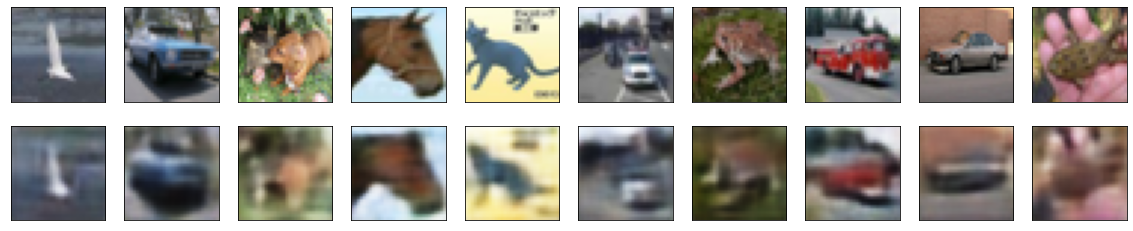

In [89]:
showOrigDec(x_test, c10test)

In [90]:
from math import log10, sqrt 
import cv2 
import numpy as np 
  
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 
  

original = x_test[0] 
compressed = c10test[0]
value = PSNR(original, compressed) 
print(f"PSNR value is {value} dB") 

PSNR value is 73.6863888289442 dB
